In [1]:
# All libs be imported
import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [7]:
# All files in src directory
from engine import Engine
from models import UNet, DiffusionLSTM, DiffusionTransformer
from frameworks import Diffusion
from utils import plot_comparison, evaluate_model, visualize_all, plot_loss_comparison, load_checkpoint
from utils.paths import VISUALIZATION_DIR, RESULTS_DIR
from ingestion import read_equity, TSFinDataset
from preprocessing import to_time_bars, to_volume_bars, to_dollar_bars

VISUALIZATION_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
config = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "symbol": "AAPL",
    "target_features": [ "Close", "Volume"], # Can be None
    "seq_length": 64, # window_size
    "batch_size": 64,
    "epochs": 500,
    "lr": 1e-4,      # learning Rate
    "d_model": 128,  # (Hidden size) -> Hidden Dimension of Model
    "layers": 2,      # Deep
    "ddpm": {
        "noise_steps": 1000,
        "beta_start": 1e-4,
        "beta_end": 0.02
    }
}

<Axes: xlabel='Date'>

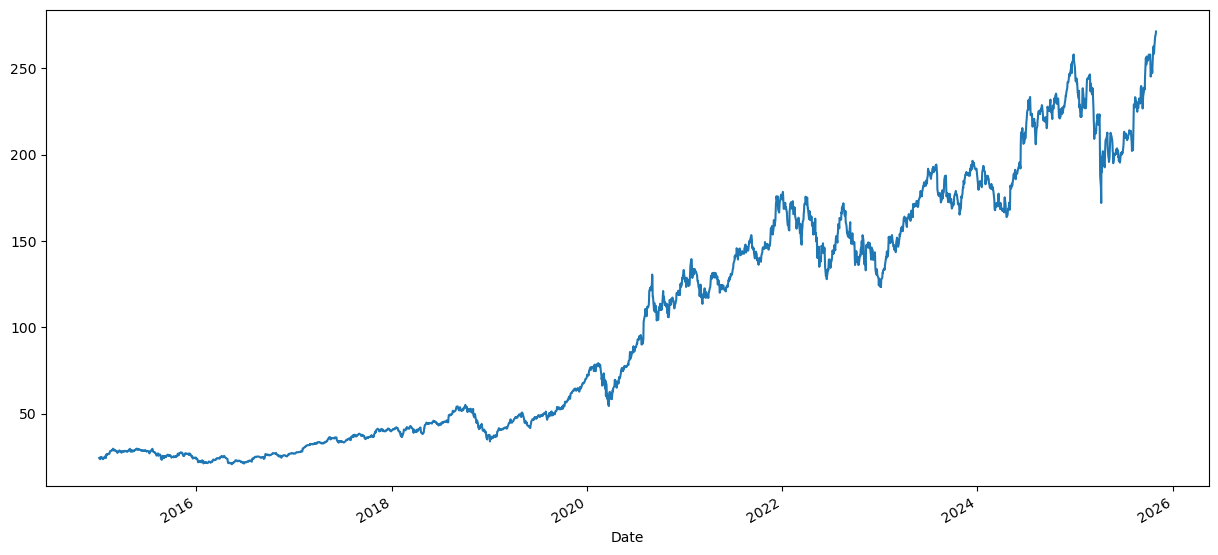

In [4]:
df = read_equity("AAPL")
df.head(3)
df["Close"].plot(figsize=(15, 7))

In [5]:
dataset = TSFinDataset(
    df,
    features=config["target_features"],
    window_size=config["seq_length"],
    use_timestamp=False,
)
input_features = dataset.get_n_features()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
sample_batch = next(iter(dataloader))
print(f"Batch Shape: {sample_batch['x'].shape}")

Batch Shape: torch.Size([32, 64, 2])


In [6]:
model = DiffusionTransformer(
                    features_in=input_features,
                    d_model=128,    # NN Size
                    nhead=4,        # number of Attention Head
                    num_layers=3,   # Deep
                    max_len=config["seq_length"]
                ).to(config["device"])

optimizer = optim.AdamW(model.parameters(), lr=config["lr"]) 
diffusion = Diffusion(
    noise_steps = config["ddpm"]["noise_steps"],
    beta_start = config["ddpm"]["beta_start"],
    beta_end = config["ddpm"]["beta_end"],
    length= config["seq_length"],
    channels= input_features,
    device = config["device"]
)
    
# engine = Engine(dataloader, diffusion, model, optimizer, device=config["device"])
# engine.fit(epochs=config["epochs"])

Batch Shape: torch.Size([32, 64, 2])


In [7]:
models = {}
history = {}

models["DDPM_UNet"] = UNet(
                    c_in=input_features,
                    c_out=input_features,
                    time_dim=256
                  ).to(config["device"])

models["DDPM_Transformer"] = DiffusionTransformer(
                    features_in=input_features,
                    d_model=128,    # ขนาดสมอง (ยิ่งเยอะยิ่งเก่ง แต่ช้า)
                    nhead=4,        # จำนวนหัว Attention
                    num_layers=3,   # ความลึก
                    max_len=config["seq_length"]
                ).to(config["device"])

models["DDPM_LSTM"] = DiffusionLSTM(
                    features_in=input_features,
                    hidden_dim=config["d_model"], # ใช้ parameter เดียวกันแต่อ้างอิงคนละชื่อ
                    num_layers=config["layers"]
                ).to(config["device"])

In [10]:
model_pth = os.path.join(RESULTS_DIR, "checkpoints", "ddpm_diffusiontransformer_0496_20251128_173134.pt")
ckpt = load_checkpoint(model_pth)

try:
    model.load_state_dict(ckpt)
except:
    model.load_state_dict(ckpt["model_state_dict"])

model.eval()

/home/narodom.y@FUSION.LAB/research/src/utils/helper.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


NameError: name 'model' is not defined

In [ ]:
for name, model in models.items():
    print(f"Training Model: {name}")
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"]) 
    
    diffusion = Diffusion(
        noise_steps = config["ddpm"]["noise_steps"],
        beta_start = config["ddpm"]["beta_start"],
        beta_end = config["ddpm"]["beta_end"],
        length=config["seq_length"],
        channels=input_features,
        device = config["device"]
    )
    
    engine = Engine(dataloader, diffusion, model, optimizer, device=config["device"])
    engine.fit(epochs=config["epochs"])
    
    history[name] = engine.history["loss"]

    real_batch = next(iter(dataloader)) 
    x_real = real_batch["x"].cpu().numpy()
    x_fake = diffusion.sample(model, n=len(x_real)).cpu().numpy()
    visualize_all(x_real, x_fake, model_name=name, save_dir=VISUALIZATION_DIR)
    
    print(f"✅ {name} Finished!\n")
    

Training Model: DDPM_UNet


Epoch 0/500: 100%|██████████| 84/84 [00:07<00:00, 10.61it/s, MSELoss=0.1117]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0000_20251128_160803.pt


Epoch 8/500: 100%|██████████| 84/84 [00:07<00:00, 11.49it/s, MSELoss=0.0338]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0008_20251128_160902.pt


Epoch 16/500: 100%|██████████| 84/84 [00:07<00:00, 11.51it/s, MSELoss=0.0747]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0016_20251128_161001.pt


Epoch 24/500: 100%|██████████| 84/84 [00:07<00:00, 11.47it/s, MSELoss=0.0825]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0024_20251128_161100.pt


Epoch 32/500: 100%|██████████| 84/84 [00:07<00:00, 11.50it/s, MSELoss=0.0848]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0032_20251128_161159.pt


Epoch 40/500: 100%|██████████| 84/84 [00:07<00:00, 11.52it/s, MSELoss=0.1654]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0040_20251128_161259.pt


Epoch 48/500: 100%|██████████| 84/84 [00:07<00:00, 11.55it/s, MSELoss=0.2213]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0048_20251128_161358.pt


Epoch 56/500: 100%|██████████| 84/84 [00:07<00:00, 11.24it/s, MSELoss=0.0964]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0056_20251128_161458.pt


Epoch 64/500: 100%|██████████| 84/84 [00:07<00:00, 11.52it/s, MSELoss=0.1023]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0064_20251128_161558.pt


Epoch 72/500: 100%|██████████| 84/84 [00:07<00:00, 11.47it/s, MSELoss=0.0394]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0072_20251128_161658.pt


Epoch 80/500: 100%|██████████| 84/84 [00:07<00:00, 11.49it/s, MSELoss=0.0731]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0080_20251128_161758.pt


Epoch 88/500: 100%|██████████| 84/84 [00:07<00:00, 11.51it/s, MSELoss=0.0266]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0088_20251128_161858.pt


Epoch 96/500: 100%|██████████| 84/84 [00:07<00:00, 11.54it/s, MSELoss=0.0778]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0096_20251128_161957.pt


Epoch 104/500: 100%|██████████| 84/84 [00:07<00:00, 11.13it/s, MSELoss=0.0410]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0104_20251128_162059.pt


Epoch 112/500: 100%|██████████| 84/84 [00:07<00:00, 11.55it/s, MSELoss=0.0471]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0112_20251128_162200.pt


Epoch 120/500: 100%|██████████| 84/84 [00:07<00:00, 11.53it/s, MSELoss=0.0400]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0120_20251128_162259.pt


Epoch 128/500: 100%|██████████| 84/84 [00:07<00:00, 11.51it/s, MSELoss=0.0771]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0128_20251128_162359.pt


Epoch 136/500: 100%|██████████| 84/84 [00:07<00:00, 11.52it/s, MSELoss=0.0345]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0136_20251128_162458.pt


Epoch 144/500: 100%|██████████| 84/84 [00:07<00:00, 11.55it/s, MSELoss=0.0866]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0144_20251128_162558.pt


Epoch 152/500: 100%|██████████| 84/84 [00:07<00:00, 11.55it/s, MSELoss=0.0272]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0152_20251128_162658.pt


Epoch 160/500: 100%|██████████| 84/84 [00:07<00:00, 11.57it/s, MSELoss=0.0389]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0160_20251128_162758.pt


Epoch 168/500: 100%|██████████| 84/84 [00:07<00:00, 11.56it/s, MSELoss=0.0742]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0168_20251128_162858.pt


Epoch 176/500: 100%|██████████| 84/84 [00:07<00:00, 11.53it/s, MSELoss=0.0674]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0176_20251128_162957.pt


Epoch 184/500: 100%|██████████| 84/84 [00:07<00:00, 11.50it/s, MSELoss=0.0522]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0184_20251128_163059.pt


Epoch 192/500: 100%|██████████| 84/84 [00:07<00:00, 11.51it/s, MSELoss=0.0518]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0192_20251128_163158.pt


Epoch 200/500: 100%|██████████| 84/84 [00:07<00:00, 11.50it/s, MSELoss=0.0977]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0200_20251128_163258.pt


Epoch 208/500: 100%|██████████| 84/84 [00:07<00:00, 11.53it/s, MSELoss=0.0905]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0208_20251128_163359.pt


Epoch 216/500: 100%|██████████| 84/84 [00:07<00:00, 11.51it/s, MSELoss=0.0341]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0216_20251128_163500.pt


Epoch 224/500: 100%|██████████| 84/84 [00:07<00:00, 11.52it/s, MSELoss=0.0288]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0224_20251128_163600.pt


Epoch 232/500: 100%|██████████| 84/84 [00:07<00:00, 11.51it/s, MSELoss=0.0530]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0232_20251128_163700.pt


Epoch 240/500: 100%|██████████| 84/84 [00:07<00:00, 11.55it/s, MSELoss=0.0255]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0240_20251128_163802.pt


Epoch 248/500: 100%|██████████| 84/84 [00:07<00:00, 11.56it/s, MSELoss=0.0894]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0248_20251128_163901.pt


Epoch 256/500: 100%|██████████| 84/84 [00:07<00:00, 11.54it/s, MSELoss=0.0359]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0256_20251128_164002.pt


Epoch 264/500: 100%|██████████| 84/84 [00:07<00:00, 11.53it/s, MSELoss=0.0435]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0264_20251128_164102.pt


Epoch 272/500: 100%|██████████| 84/84 [00:07<00:00, 11.51it/s, MSELoss=0.0465]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0272_20251128_164202.pt


Epoch 280/500: 100%|██████████| 84/84 [00:07<00:00, 11.52it/s, MSELoss=0.0260]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0280_20251128_164301.pt


Epoch 288/500: 100%|██████████| 84/84 [00:07<00:00, 11.51it/s, MSELoss=0.0788]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0288_20251128_164401.pt


Epoch 296/500: 100%|██████████| 84/84 [00:07<00:00, 11.49it/s, MSELoss=0.0429]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0296_20251128_164502.pt


Epoch 304/500: 100%|██████████| 84/84 [00:07<00:00, 11.54it/s, MSELoss=0.0251]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0304_20251128_164602.pt


Epoch 312/500: 100%|██████████| 84/84 [00:07<00:00, 11.49it/s, MSELoss=0.0107]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0312_20251128_164701.pt


Epoch 320/500: 100%|██████████| 84/84 [00:07<00:00, 11.49it/s, MSELoss=0.0554]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0320_20251128_164801.pt


Epoch 328/500: 100%|██████████| 84/84 [00:07<00:00, 11.49it/s, MSELoss=0.0389]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0328_20251128_164901.pt


Epoch 336/500: 100%|██████████| 84/84 [00:07<00:00, 11.48it/s, MSELoss=0.0242]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0336_20251128_165000.pt


Epoch 344/500: 100%|██████████| 84/84 [00:07<00:00, 11.46it/s, MSELoss=0.0493]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0344_20251128_165101.pt


Epoch 352/500: 100%|██████████| 84/84 [00:07<00:00, 11.52it/s, MSELoss=0.0135]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0352_20251128_165202.pt


Epoch 360/500: 100%|██████████| 84/84 [00:07<00:00, 11.48it/s, MSELoss=0.0315]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0360_20251128_165304.pt


Epoch 368/500: 100%|██████████| 84/84 [00:07<00:00, 11.50it/s, MSELoss=0.0411]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0368_20251128_165405.pt


Epoch 376/500: 100%|██████████| 84/84 [00:07<00:00, 11.52it/s, MSELoss=0.0187]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0376_20251128_165505.pt


Epoch 384/500: 100%|██████████| 84/84 [00:07<00:00, 11.52it/s, MSELoss=0.0159]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0384_20251128_165606.pt


Epoch 392/500: 100%|██████████| 84/84 [00:07<00:00, 11.51it/s, MSELoss=0.0413]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0392_20251128_165705.pt


Epoch 400/500: 100%|██████████| 84/84 [00:07<00:00, 11.47it/s, MSELoss=0.0124]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0400_20251128_165808.pt


Epoch 408/500: 100%|██████████| 84/84 [00:07<00:00, 11.50it/s, MSELoss=0.0296]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0408_20251128_165910.pt


Epoch 416/500: 100%|██████████| 84/84 [00:07<00:00, 11.46it/s, MSELoss=0.0408]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0416_20251128_170009.pt


Epoch 424/500: 100%|██████████| 84/84 [00:07<00:00, 11.51it/s, MSELoss=0.0165]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0424_20251128_170109.pt


Epoch 432/500: 100%|██████████| 84/84 [00:07<00:00, 11.56it/s, MSELoss=0.0360]


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_unet_0432_20251128_170208.pt


Epoch 433/500:  12%|█▏        | 10/84 [00:00<00:06, 11.40it/s, MSELoss=0.0392]

In [ ]:
print("\n📈 Plotting Final Comparison...")
plot_loss_comparison(history, save_dir=VISUALIZATION_DIR)
print("🎉 All Experiments Completed!")